Goal = predict the 9 month recover given that we have 3 month data.

In [1]:
# Import core libraries.
import pandas as pd 
import numpy as np
import datetime
from collections import Counter 

# Import visualisation libraries.
import matplotlib.pyplot as plt
import seaborn as sns 

# Import preprocessing libraries.
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, StratifiedKFold, 
                                     cross_validate, RandomizedSearchCV)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer

# Import machine learning libraries.
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier 

# Import evaluation libraries.
from sklearn.metrics import (accuracy_score, roc_auc_score, confusion_matrix, 
                             classification_report, precision_score, recall_score,
                             f1_score, ConfusionMatrixDisplay)
import shap

# Define global seed.
SEED = 42

In [2]:
# Import the dataset.
trial_data = pd.read_csv('../data/raw/Bells Palsy Clinical Trial.csv')

# View the dataset.
display(trial_data.head())
print('Number of examples:', trial_data.shape[0])
print('Number of features:', trial_data.shape[1])
print('Feature names:', trial_data.columns.values)

,Patient ID,Sex,Age,Baseline Score on House–Brackmann scale,Time between onset of symptoms and start of treatment,Treatment Group,Received Prednisolone,Received Acyclovir,3-Month Score on House–Brackmann scale,Full Recovery in 3 Months,9-Month Score on House–Brackmann scale,Full Recovery in 9 Months
0,1,Female,77,6,Within 24 hr,Prednisolone–Placebo,Yes,No,2,No,2,No
1,2,Female,61,6,Within 24 hr,Prednisolone–Placebo,Yes,No,1,Yes,1,Yes
2,3,Female,46,4,>24 to ≤48 hr,Prednisolone–Placebo,Yes,No,1,Yes,1,Yes
3,4,Female,46,3,Within 24 hr,Prednisolone–Placebo,Yes,No,1,Yes,1,Yes
4,5,Female,42,3,>24 to ≤48 hr,Prednisolone–Placebo,Yes,No,1,Yes,1,Yes


Number of examples: 494
Number of features: 12
Feature names: ['Patient ID' 'Sex' 'Age' 'Baseline Score on House–Brackmann scale'
 'Time between onset of symptoms and start of treatment' 'Treatment Group'
 'Received Prednisolone' 'Received Acyclovir'
 '3-Month Score on House–Brackmann scale' 'Full Recovery in 3 Months'
 '9-Month Score on House–Brackmann scale' 'Full Recovery in 9 Months']


Full recovery in 9 months will be used as the primary target (1 = fully recovery, 0 = not fully recovered). 

In [3]:
# Create a copy of the dataset for cleaning.
trial_data_clean = trial_data.copy()

In [4]:
# Check the feature data types.
trial_data_clean.dtypes

Patient ID                                                int64
Sex                                                      object
Age                                                       int64
Baseline Score on House–Brackmann scale                   int64
Time between onset of symptoms and start of treatment    object
Treatment Group                                          object
Received Prednisolone                                    object
Received Acyclovir                                       object
3-Month Score on House–Brackmann scale                    int64
Full Recovery in 3 Months                                object
9-Month Score on House–Brackmann scale                    int64
Full Recovery in 9 Months                                object
dtype: object

In [5]:
# Convert binary features.
trial_data_clean['Received Prednisolone'] = (trial_data_clean['Received Prednisolone'] == 'Yes').astype(int)
trial_data_clean['Received Acyclovir'] = (trial_data_clean['Received Acyclovir'] == 'Yes').astype(int)
trial_data_clean['Did Not Recover'] = (trial_data_clean['Full Recovery in 9 Months'] == 'No').astype(int)

In [6]:
# Check for missing values.
print(trial_data_clean.isnull().sum())

Patient ID                                               0
Sex                                                      0
Age                                                      0
Baseline Score on House–Brackmann scale                  0
Time between onset of symptoms and start of treatment    0
Treatment Group                                          0
Received Prednisolone                                    0
Received Acyclovir                                       0
3-Month Score on House–Brackmann scale                   0
Full Recovery in 3 Months                                0
9-Month Score on House–Brackmann scale                   0
Full Recovery in 9 Months                                0
Did Not Recover                                          0
dtype: int64


In [7]:
# Check for duplicated rows.
print('Number of duplicated rows:',int(trial_data_clean.duplicated().sum()))

Number of duplicated rows: 0


In [8]:
# Check for high cardinality in categorical columns.
categorical_cols = trial_data_clean.select_dtypes(include=['object']).columns
high_cardinality_cols = [col for col in categorical_cols if trial_data_clean[col].nunique() > 50]

print('High cardinality columns:', list(high_cardinality_cols))

High cardinality columns: []


In [9]:
# Drop redundant/ leaky features.
trial_data_clean = trial_data_clean.drop(['Patient ID', 'Full Recovery in 3 Months',
                                          '9-Month Score on House–Brackmann scale', 
                                          'Full Recovery in 9 Months'], axis=1)

In [10]:
# Save cleaned dataset.
trial_data_clean.to_csv('trial_data_cleaned.csv', index=False)

In [11]:
# Create a copy of the cleaned dataset for feature engineering.
trial_data_fe = trial_data_clean.copy()

In [12]:
# View features.
print(trial_data_fe.columns)

Index(['Sex', 'Age', 'Baseline Score on House–Brackmann scale',
       'Time between onset of symptoms and start of treatment',
       'Treatment Group', 'Received Prednisolone', 'Received Acyclovir',
       '3-Month Score on House–Brackmann scale', 'Did Not Recover'],
      dtype='object')


In [13]:
# Function to a plot seaborn countplot of a categorical variable.
def countplot(df, x, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    sns.countplot(df, x=x, palette='mako', hue=x, ax=ax)
    ax.set_title(f'{x} Distribution')

In [14]:
# Function to plot a barplot of terminated percentage by categorical variable.
def recovered_percent(df, x, ax=None):
    terminated = (df.groupby(x, observed=True)['Did Not Recover']
                .value_counts(normalize=True)
                .rename('Percentage')
                .reset_index())
    
    terminated = terminated[terminated['Did Not Recover'] == 1]
    terminated['Percentage'] *= 100

    if ax is None:
        _, ax = plt.subplots(figsize=(6, 4))

    sns.barplot(terminated, x=x, y='Percentage', palette='mako', hue=x, ax=ax)
    ax.set_title(f'Did Not Recover % by {x}')
    ax.set_ylabel('Percentage of Did Not Recover')

In [15]:
trial_data_fe.columns

Index(['Sex', 'Age', 'Baseline Score on House–Brackmann scale',
       'Time between onset of symptoms and start of treatment',
       'Treatment Group', 'Received Prednisolone', 'Received Acyclovir',
       '3-Month Score on House–Brackmann scale', 'Did Not Recover'],
      dtype='object')

In [16]:
# Define the categorical columns.
categorical_cols = ['Sex', 'Time between onset of symptoms and start of treatment',
       'Treatment Group', 'Received Prednisolone', 'Received Acyclovir']

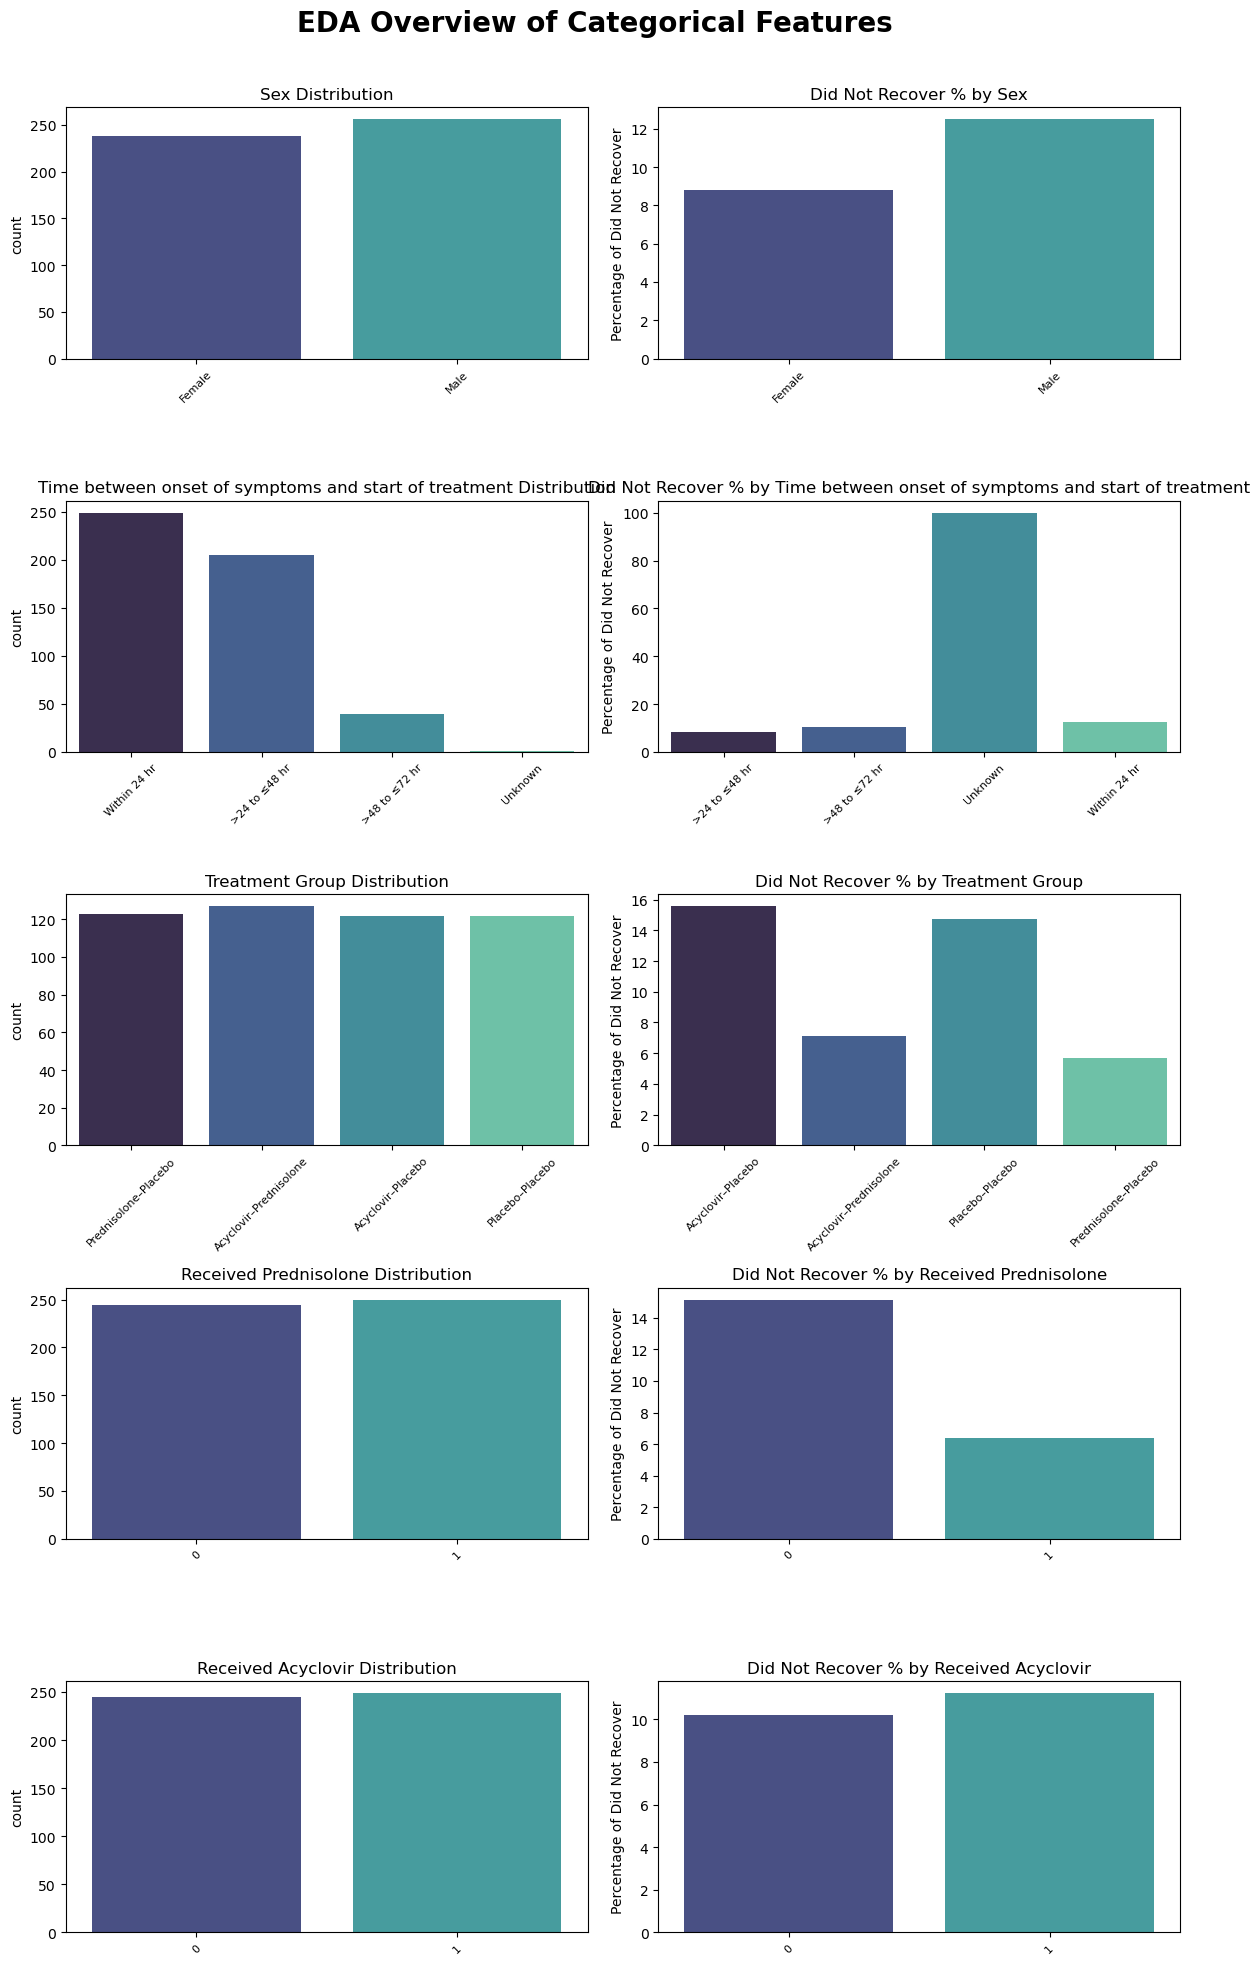

In [17]:
# Plot the distribution and percentage terminated for categorical and binary features.
fig, axes = plt.subplots(len(categorical_cols), 2, figsize=(12, 20))

for i, col in enumerate(categorical_cols):

    # # Use the filtered dataframe if col is branch or condition group.
    # if col == 'CARE_RECIPIENT_BRANCH':
    #     df = top_branch_df
    # elif col == 'PRIMARY_CONDITION_GROUP':
    #     df = top_primary_df
    # elif col == 'SECONDARY_CONDITION_GROUP':
    #     df = top_secondary_df
    # else:
    #     df = care_data_fe

    # Plot distribution and dropout percentage.
    countplot(trial_data_fe, col, ax=axes[i, 0])
    recovered_percent(trial_data_fe, col, ax=axes[i, 1])

# Remove legends for clarity.
for ax_row in axes:
    for ax in ax_row:
        if ax.get_legend() is not None:
            ax.get_legend().remove()
        ax.tick_params(axis='x', rotation=45, labelsize=8)
        ax.set_xlabel('')

fig.suptitle('EDA Overview of Categorical Features', fontsize=20, weight='bold')
fig.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

In [18]:
# Define numerical features.
numerical_features = list(['Age', 'Baseline Score on House–Brackmann scale', 
                      '3-Month Score on House–Brackmann scale'])

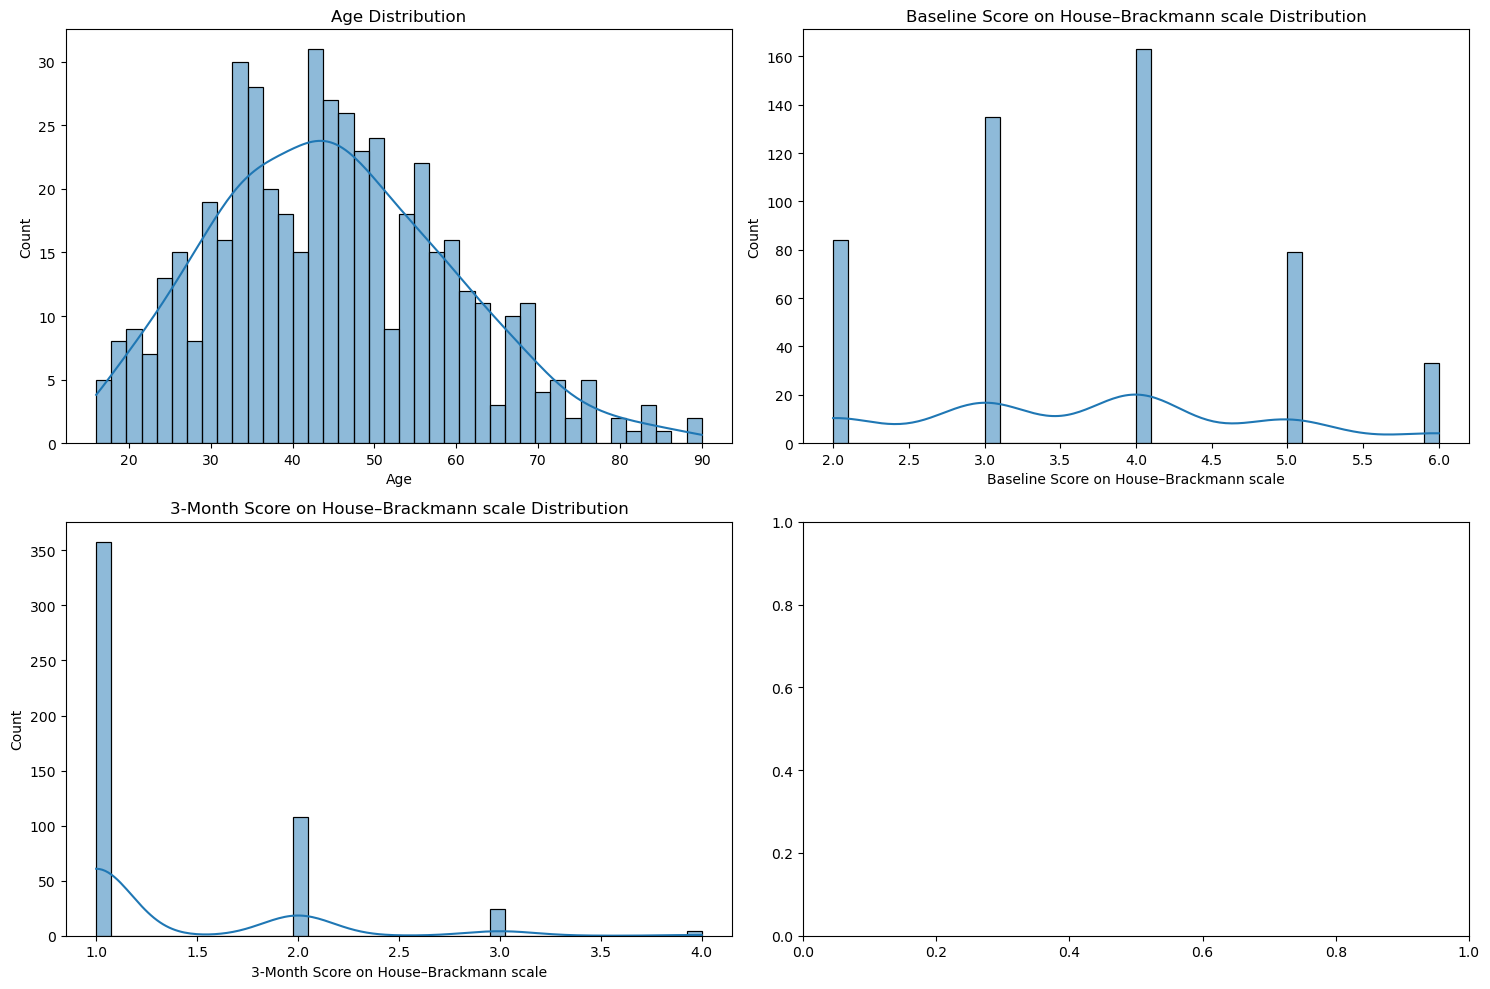

In [19]:
# View distribution of numerical features.
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for col, ax in zip(numerical_features, axes.ravel()):
    
    sns.histplot(trial_data_fe[col], bins=40, kde=True, ax=ax)
    ax.set_title(f'{col} Distribution')
plt.tight_layout()
plt.show()

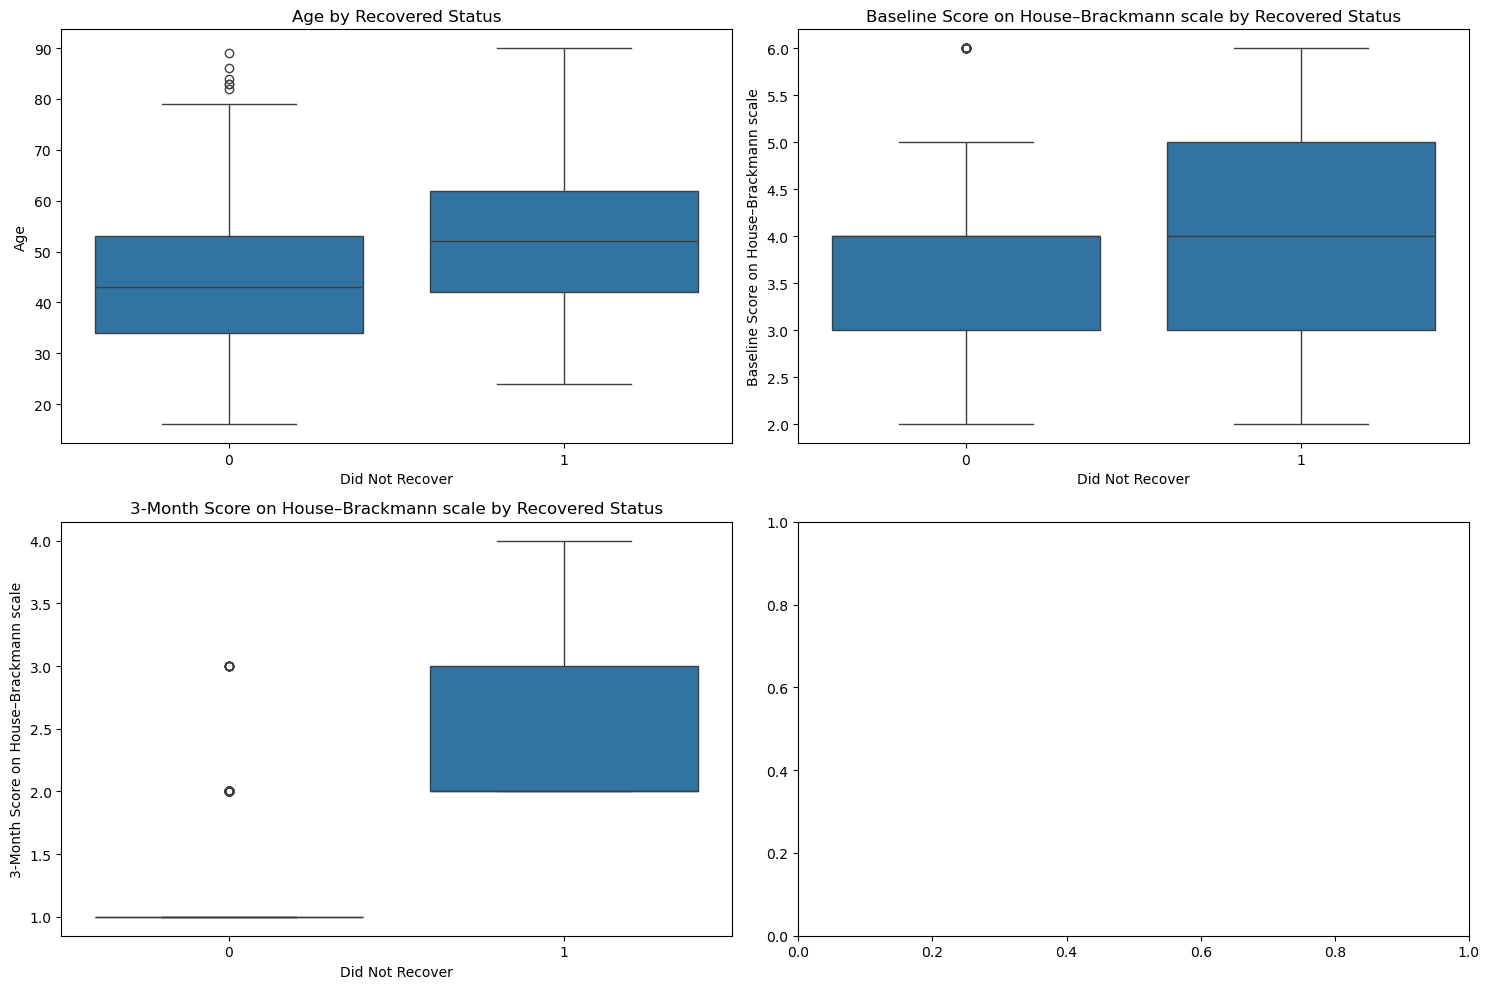

In [20]:
# View boxplots of numerical features.
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
for col, ax in zip(numerical_features, axes.ravel()):
    
    sns.boxplot(data=trial_data_fe, x='Did Not Recover', y=col, ax=ax)
    ax.set_title(f'{col} by Recovered Status')
plt.tight_layout()
plt.show()

In [21]:
# View target feature class distribution.
trial_data_fe['Did Not Recover'].value_counts(normalize=True).rename_axis('Did Not Recover (%)').mul(100).round(1)

Did Not Recover (%)
0    89.3
1    10.7
Name: proportion, dtype: float64

In [22]:
# Split into target and feature variables.
X = trial_data_fe.drop('Did Not Recover', axis=1)
y = trial_data_fe['Did Not Recover']

In [23]:
# Define binary, numerical and categorical features.
numerical_features = X.select_dtypes(include=['number']).columns
binary_cols = [col for col in numerical_features if X[col].nunique() == 2]
numerical_cols = [col for col in numerical_features if col not in binary_cols]

categorical_cols = X.select_dtypes(include=['object']).columns

print('Binary columns:', list(binary_cols))
print('Numerical columns:', list(numerical_cols))
print('Categorical columns:', list(categorical_cols))

Binary columns: ['Received Prednisolone', 'Received Acyclovir']
Numerical columns: ['Age', 'Baseline Score on House–Brackmann scale', '3-Month Score on House–Brackmann scale']
Categorical columns: ['Sex', 'Time between onset of symptoms and start of treatment', 'Treatment Group']


In [24]:
trial_data_fe['Time between onset of symptoms and start of treatment'].unique()

array(['Within 24 hr', '>24 to ≤48 hr', '>48 to ≤72 hr', 'Unknown'],
      dtype=object)

In [25]:
# Define ordinal and nominal columns. 
ordinal_cols = ['Time between onset of symptoms and start of treatment']

nominal_cols = ['Sex', 'Treatment Group']

# Define ordinal order, left out 'Unknown' to ensure it is encoded as -1 in pipeline.
ordinal_order = {
    'Time between onset of symptoms and start of treatment': ['Within 24 hr', '>24 to ≤48 hr', '>48 to ≤72 hr']
}

In [26]:
# Define transformers. 
ordinal_transformer = Pipeline(
    steps=[
        ('encoder', OrdinalEncoder(
               categories=[
                   ordinal_order['Time between onset of symptoms and start of treatment']
                   ],
               handle_unknown = 'use_encoded_value',
               unknown_value= -1                                # encoded 'Unknown' as -1. 
           ))
           ]
           )

nominal_transformer = Pipeline(
    steps=[
        ('encode', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ]
)

In [27]:
# Build preprocessor.
preprocessor = ColumnTransformer(
     transformers=[
          ('numeric', 'passthrough', numerical_cols),
          ('binary', 'passthrough', binary_cols),
          ('ordinal', ordinal_transformer, ordinal_cols),
          ('nominal', nominal_transformer, nominal_cols)
     ]
)

In [28]:
# Split data into training and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)

In [29]:
# Count examples in each class
counter = Counter(y_train)

# Estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 8.405


In [30]:
# Create classifier instance.
xgb_model = XGBClassifier(scale_pos_weight=estimate, random_state=SEED)

In [31]:
# Define pipeline 
xgb_pipeline = Pipeline(
    steps=[('preprocessing', preprocessor),
           ('classifier', xgb_model)]
)

# Define cross validation method.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

scoring = ['recall', 'precision', 'f1', 'accuracy', 'roc_auc']

baseline_scores = cross_validate(
    xgb_pipeline, 
    X_train,
    y_train, 
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    verbose=0
)

baseline_results = pd.DataFrame(baseline_scores)
mean_scores = pd.DataFrame(baseline_results.mean().to_frame('Mean'))
display(mean_scores)

,Mean
fit_time,0.014735
score_time,0.011725
test_recall,0.605556
test_precision,0.477662
test_f1,0.529939
test_accuracy,0.888608
test_roc_auc,0.922433


In [ ]:
# Define parameter grid for tuning.
params_grid = {
    'classifier__max_depth': [5, 7],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__n_estimators': [500, 800]
}

In [ ]:
# Run grid search with recall set as scoring metric.
xgb_grid_search = GridSearchCV(
    estimator=xgb_pipeline,
    param_grid=params_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=cv,
    refit='recall', # refit best model on full training set
    verbose=0
)

# Train the model.
xgb_grid_search.fit(X_train, y_train)


In [ ]:
# Summary table of results.
results_df = pd.DataFrame(xgb_grid_search.cv_results_)
metric_cols = ['mean_test_recall', 'mean_test_precision', 'mean_test_f1', 'mean_test_accuracy', 'mean_test_roc_auc']
results_df = results_df.loc[:, metric_cols]

display(pd.DataFrame(results_df.apply('mean').to_frame('Tuned Results')))

In [ ]:
# View best parameters.
print(xgb_grid_search.best_params_)

In [ ]:
# Define the best model pipeline (model already refit on entire training set).
best_xgb_model = xgb_grid_search.best_estimator_

In [ ]:
# Function to generate model predictions on test set and evaluate.
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    a = accuracy_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    r = recall_score(y_test, y_pred)
    p = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm_matrix = confusion_matrix(y_test, y_pred)

    evaluation = pd.DataFrame({"Accuracy": [a],
                             "AUC ROC": [roc],
                             "Recall": [r],
                             "Precision": [p],
                             "F1 Score": [f1]},
                            index = [model_name])

    return evaluation, cm_matrix

In [ ]:
# Generate predictions on hold-out test set and evaluate.
evaluation, cm_matrix = evaluate_model(best_xgb_model, X_test, y_test, 'XGBoost')

In [ ]:
# View results.
display(evaluation)

In [ ]:
# View confusion matrix.
ConfusionMatrixDisplay(confusion_matrix=cm_matrix).plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Tuned XGBoost (Test)')
plt.show()

In [ ]:
# Extract preprocessor and classifier from final pipeline.
preprocessor = best_xgb_model.named_steps['preprocessing']
final_xgb_model = best_xgb_model.named_steps['classifier']

# Transform data (as seen by the model)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Extract feature names generated by encoding.
feature_names = preprocessor.get_feature_names_out()

# Build explainer.
explainer = shap.TreeExplainer(final_xgb_model, data=X_train_transformed)

# Compute SHAP values.
shap_values = explainer.shap_values(X_test_transformed)

In [ ]:
# Global feature importance bar plot.
shap.summary_plot(
    shap_values,
    X_test_transformed,
    feature_names=feature_names,
    plot_type='bar',
    plot_size=(10,5),
    show=False
)

fig = plt.gcf()
ax = fig.axes[0]              
ax.tick_params(axis='y', labelsize=8)
ax.xaxis.label.set_fontsize(8)
ax.tick_params(axis='x', labelsize=9)

plt.title('SHAP Feature Importance (Test Set)')
plt.tight_layout()
plt.show()

In [ ]:
# Detailed impact plot (beeswarm).
shap.summary_plot(
    shap_values, 
    X_test_transformed, 
    feature_names, 
    plot_size=(15,5),
    show=False)

fig = plt.gcf()
ax = fig.axes[0]              
ax.tick_params(axis='y', labelsize=8)
ax.xaxis.label.set_fontsize(8)
ax.tick_params(axis='x', labelsize=9)

plt.title('SHAP Summary (Test Set)')
plt.show()